<a href="https://colab.research.google.com/github/chohk3/polypeptide-/blob/main/UNet_with_Annotations_Rectus_Abdominis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and connect to google drive for data access

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import skimage.morphology as mo

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set up training dataloader, validation dataloader

Dataloader is a component that helps efficiently load and preprocess large amounts of data for training a machine learning model. It takes care of loading the data from a specified data source, such as a database or file system, and prepares it for use in the training process.

In particular, a dataloader typically performs the following operations:

1. Reads the raw data from the data source.
2. Applies any necessary preprocessing steps to the data, such as normalization, data augmentation, or feature engineering.
3. Divides the data into batches of a specified size, so that the model can be trained on small subsets of the data at a time.
4. Shuffles the data randomly to prevent the model from overfitting on any particular subset of the data.
5. Optionally, performs additional operations such as caching or parallelization to speed up the data loading process. We are not doing this in this UNet.

Dataloaders are an essential component of deep learning training, as they allow models to be trained on large datasets that would otherwise be difficult or impossible to load and process efficiently. They are often used in conjunction with deep learning frameworks such as PyTorch or TensorFlow, which provide built-in support for dataloading and other training-related tasks.

In [ ]:
validation_set_size = 0.2 # Set up the % of data to be validation dataset

In [ ]:
# The dataloader basically contains batches of images and their corresponding masks

class Muscle(Dataset):
  def __init__(self, train = True, transformX = None, transformY = None):
    # I have previously created a file named 500_train.csv using the file names. Here we will read in the csv to access data in google drive.
    # hayo: should this be 300_train.csv??
    self.pixel_file = pd.read_csv('/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data/300_train.csv')
    self.transformX = transformX
    self.transformY = transformY
    self.train = train

    # Split the dataset to train and validation using sklearn function train_test_split
    self.train_data, self.validation_data = train_test_split(self.pixel_file,
                                                                test_size = validation_set_size,
                                                                random_state = 5)
  def __len__(self):
    if self.train:
      return len(self.train_data)
    return len(self.validation_data)

  def __getitem__(self, index):
    train_path = '/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data/train_data'

    if self.train:
      imx_name = os.path.join(train_path, self.train_data.iloc[index, 1])
      imy_name = os.path.join(train_path, self.train_data.iloc[index, 1].replace('.jpeg','_mask.jpg'))
    else:
      imx_name = os.path.join(train_path, self.validation_data.iloc[index, 1])
      imy_name = os.path.join(train_path, self.validation_data.iloc[index, 1].replace('.jpeg','_mask.jpg'))

    # original image
    imx = Image.open(imx_name)

    # mask for the image
    imy = Image.open(imy_name).convert('L')

    if self.train:
      # Random horizontal flipping
      if random.random() > 0.5:
        imx = TF.hflip(imx)
        imy = TF.hflip(imy)

      # Random vertical flipping
      if random.random() > 0.5:
        imx = TF.vflip(imx)
        imy = TF.vflip(imy)

      # Random rotation
      if random.random() > 0.8:
        angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
        imx = TF.rotate(imx, angle)
        imy = TF.rotate(imy, angle)

    # We will use resize, tensorlize, and normalize in the following cell
    if self.transformX :
      imx = self.transformX(imx)
      imy = self.transformY(imy)

    sample = {'image': imx, 'mask': imy}
    return sample

In [ ]:
# Init transform functions
tx_X = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),  ################ no need to normalize the mask
                           # transforms.Normalize((0.5,), (0.5,))
                          ])
train_data = Muscle(train = True, transformX = tx_X, transformY = tx_Y)
validation_data = Muscle(train = False, transformX = tx_X, transformY = tx_Y )

In [ ]:
# Dataloaders
batch_size=8
train_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True, num_workers = 2)
validation_loader = DataLoader(dataset = validation_data, batch_size = 8, shuffle = True, num_workers = 2)
print(len(train_loader)) #len(train_loader)*batch_size = total number of images in training set (50*8 = 400), hayo: now 30?
print(len(validation_loader)) #len(validation_loader)*batch_size = total number of images in validation set(13*8 = 104 ~ 100)

#hayo the validation_loader is now 8 instead of 13
print(len(validation_loader)*batch_size)

30
8
64


In [ ]:
# The following functions will return numpy array from the transformed tensors which were
# obtained from our train_loader. Plot them and see if they are intact
def im_converterX(tensor):
  image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy
                                              # as we will need original later
  image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
  print("image shape is ",image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image
                                              # this also outputs (28, 28, 3) which seems important for plt.imshow
  image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
  return image

def im_converterY(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  print("image shape is ",image.shape)
  image = image * np.array((1, 1, 1))
  image = image.clip(0, 1)
  return image

0 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
image shape is  (256, 256, 3)
image shape is  (256, 256, 1)
image shape is  (256, 256, 3)
image shape is  (256, 256, 1)


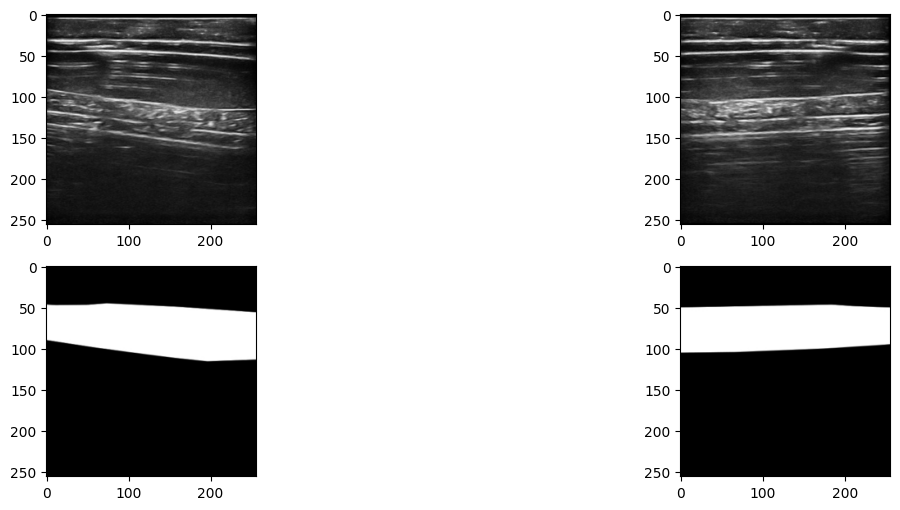

In [ ]:
## Here we loop through our train_loader and see the images
fig = plt.figure(figsize = (15,6))

for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['mask'].size())

    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['mask'][index]))
    break

# U Net


UNet is a convolutional neural network architecture that is commonly used in image segmentation tasks in deep learning. The architecture is named after its shape, which resembles the letter "U".

The UNet architecture consists of an encoder and a decoder network. The encoder network performs a series of convolutional operations to extract features from the input image, reducing the spatial dimensions of the image while increasing the number of channels (or feature maps) in each layer. The decoder network then performs a series of upsampling and concatenation operations to restore the spatial dimensions of the image, while reducing the number of channels.

The key innovation of UNet is the use of skip connections between the encoder and decoder networks. These connections allow the decoder to access high-resolution feature maps from earlier layers of the encoder, which can improve the accuracy of the segmentation results by preserving fine-grained details of the input image.

UNet has been widely used in a variety of medical imaging applications, such as segmentation of organs and tumors in MRI and CT scans. It has also been applied to other types of image segmentation tasks, such as semantic segmentation in natural images.
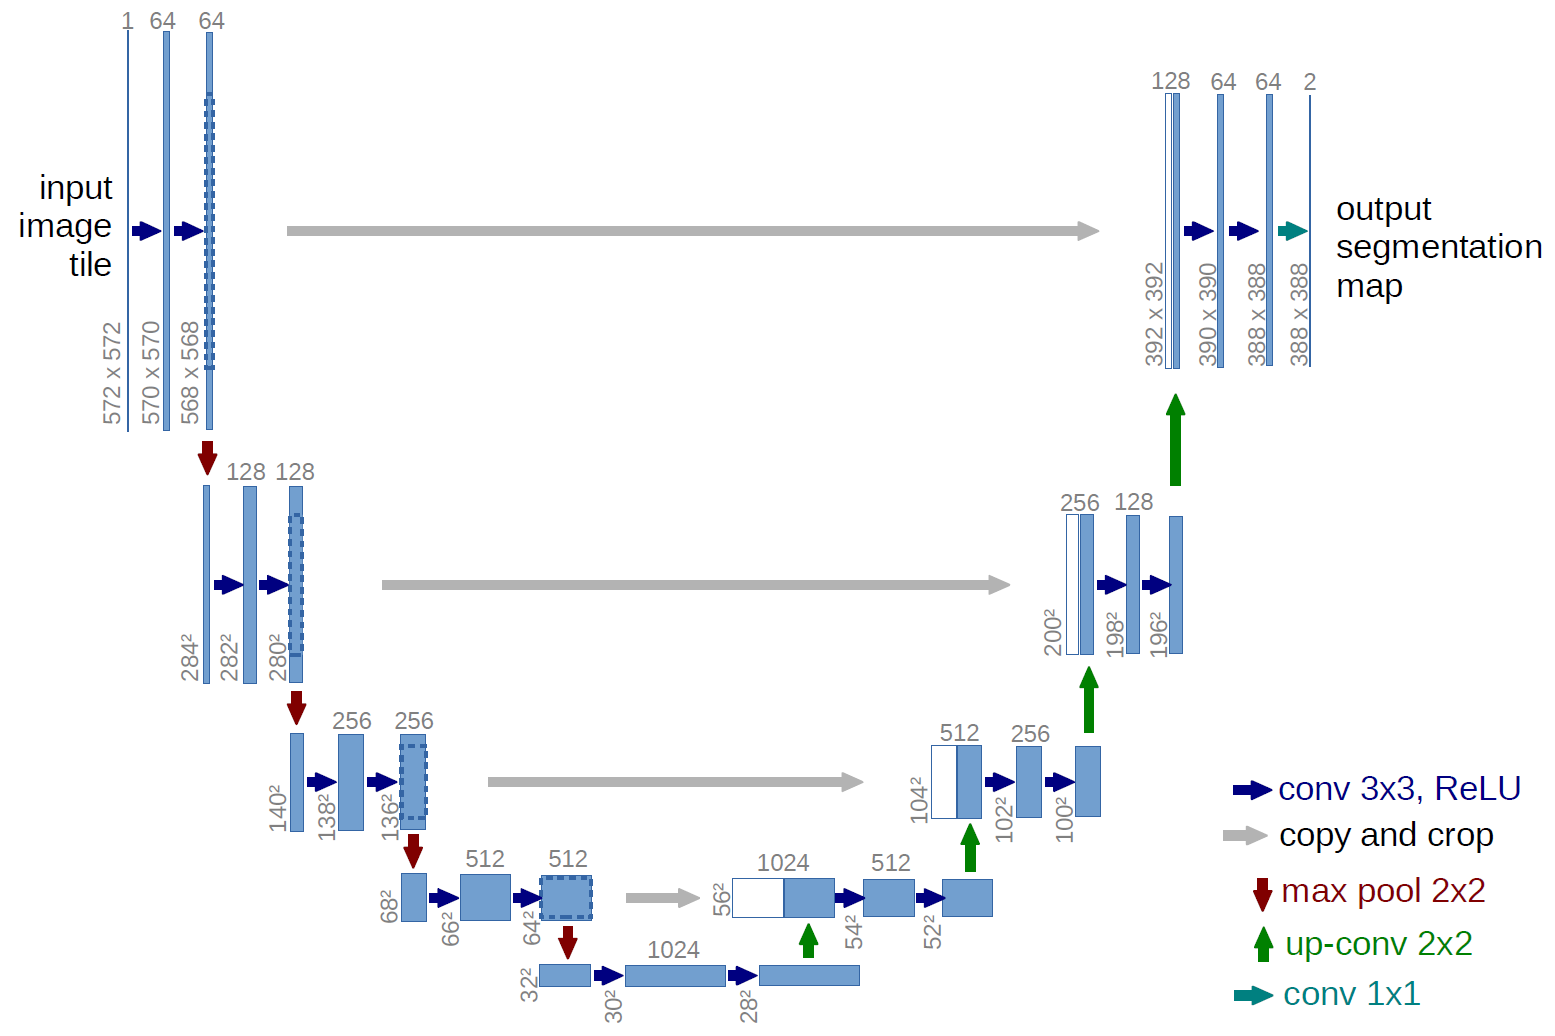
https://arxiv.org/abs/1505.04597

In [ ]:
class double_conv(nn.Module):
  '''(conv => BN => ReLU) * 2'''
  def __init__(self, in_ch, out_ch):
    super(double_conv, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, 3, padding=1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_ch, out_ch, 3, padding=1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.conv(x)
    return x

class inconv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(in_ch, out_ch)

  def forward(self, x):
    x = self.conv(x)
    return x

class down(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(down, self).__init__()
    self.mpconv = nn.Sequential(
        nn.MaxPool2d(2),
        double_conv(in_ch, out_ch)
    )

  def forward(self, x):
    x = self.mpconv(x)
    return x


class up(nn.Module):
  def __init__(self, in_ch, out_ch, bilinear=True):
    super(up, self).__init__()
    self.up = nn.Upsample(
      scale_factor=2, mode='bilinear', align_corners=True)
    self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
    self.conv = double_conv(in_ch, out_ch)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    diff1 = x2.shape[2]-x1.shape[2]
    diff2 = x2.shape[3]-x1.shape[3]
    x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
    x = torch.cat([x2, x1], dim=1)
    x = self.conv(x)
    return x


class outconv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(outconv, self).__init__()
    self.conv = nn.Conv2d(in_ch, out_ch, 1)

  def forward(self, x):
    x = self.conv(x)
    return x

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(UNet, self).__init__()
    self.inc = inconv(n_channels, 64)
    self.down1 = down(64, 128)
    self.down2 = down(128, 256)
    self.down3 = down(256, 512)
    self.down4 = down(512, 512)
    self.up1 = up(1024, 256, bilinear = False)
    self.up2 = up(512, 128, bilinear = False)
    self.up3 = up(256, 64, bilinear = False)
    self.up4 = up(128, 64, bilinear = False)
    self.outc = outconv(64, n_classes)
    self.dropout = torch.nn.Dropout2d(0.5)

  def forward(self, x):
    x = x.float()
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.dropout(x)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    x = self.outc(x)
    return torch.sigmoid(x)

# Prepare for training

In [ ]:
model = UNet(3, 1)
# hayo: had to edit model.to('cuda') bc Apple hasn't supported NVIDIA graphics cards natively in macOS since macOS Mojave
model.to('cpu')
print("Model Loaded to GPU")

Model Loaded to GPU


Loss
*   The loss is a measure of how well the neural network is performing on a given task. It represents the difference between the predicted output of the network and the true output (or label) for a particular input. The goal of the training process is to minimize the loss, which can be achieved by adjusting the weights and biases of the network through backpropagation.
*   There are several different loss functions that can be used in deep learning, depending on the specific task and type of output. Some common loss functions include mean squared error, cross-entropy loss, and binary cross-entropy loss.

Optimizer

*   The optimizer is an algorithm that updates the weights and biases of the neural network in order to minimize the loss. It works by computing the gradients of the loss with respect to the network parameters and adjusting them in the direction that reduces the loss.
*   There are several different optimizers that can be used in deep learning, each with its own advantages and disadvantages. Some common optimizers include stochastic gradient descent (SGD), Adam, and RMSprop. The choice of optimizer can have a significant impact on the training process, as some optimizers may converge more quickly or result in better performance than others.

Together, the loss and optimizer are crucial components of the training process in deep learning, as they enable the network to learn from data and improve its performance over time.

In [ ]:
criterion = nn.BCELoss() # BCE = Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # lr = learning rate

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
  smooth = 0.000001 # prevent division by 0
  size_of_batch = y_pred.size(0)

  p1 = y_pred.view(size_of_batch, -1)
  p2 = y_actual.view(size_of_batch, -1)

  intersection = (p1 * p2).sum()

  dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
  #dice.requires_grad = True

  return dice

# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  return 1 -(dice_index(y_predict, y_train))

# Training

In [ ]:
epochs = 40 # number of iterations of the training dataset during the training process

train_running_loss_history = []
validation_running_loss_history = []

model.to('cuda')

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  model.train()
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['mask'].to('cuda') # hayo: make the weight to cuda
    optimizer.zero_grad()
    y_pred = model(X_train) # hayo: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if ith_batch % 5 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
    train_running_loss += loss.item()
  else:
    with torch.no_grad():
      model.eval()
      for ith_batch, sample_batched in enumerate(validation_loader):
        X_val = sample_batched['image'].to('cuda')
        y_val = sample_batched['mask'].to('cuda')
        y_out = model(X_val)
        out_val = (y_out + 0.5).int().float()
        val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
        validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))

      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)

      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)

  torch.cuda.empty_cache()

Epoch:  1 Batch:  0 Current Loss:  0.7304144501686096
Epoch:  1 Batch:  5 Current Loss:  0.46796169877052307
Epoch:  1 Batch:  10 Current Loss:  0.38449257612228394
Epoch:  1 Batch:  15 Current Loss:  0.26002633571624756
Epoch:  1 Batch:  20 Current Loss:  0.17846053838729858
Epoch:  1 Batch:  25 Current Loss:  0.11156272888183594
Epoch 1 completed
Average train loss is 0.34758987749616305: 
Average validation loss is 2.578968971967697
Epoch:  2 Batch:  0 Current Loss:  0.08586844056844711
Epoch:  2 Batch:  5 Current Loss:  0.09916611015796661
Epoch:  2 Batch:  10 Current Loss:  0.2240695357322693
Epoch:  2 Batch:  15 Current Loss:  0.1765037477016449
Epoch:  2 Batch:  20 Current Loss:  0.08049505949020386
Epoch:  2 Batch:  25 Current Loss:  0.053160928189754486
Epoch 2 completed
Average train loss is 0.13674623171488445: 
Average validation loss is 0.06951460847631097
Epoch:  3 Batch:  0 Current Loss:  0.06205931678414345
Epoch:  3 Batch:  5 Current Loss:  0.05242403969168663
Epoch:  

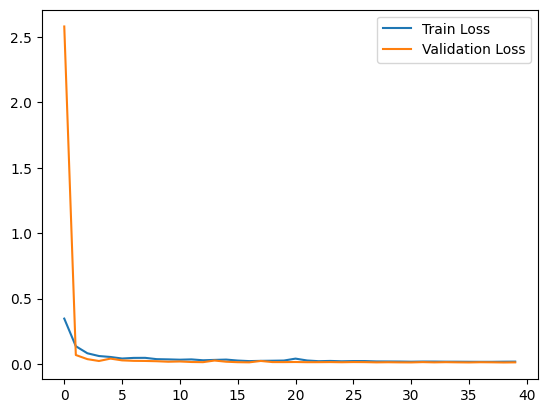

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

## Evaluation

In [ ]:
def avg_dice_index(dataloader):
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['mask'].to('cuda')
            y_predict = (model(X_train) + 0.5).int().float()
            dice += dice_index(y_predict, y_train)
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)

0.9870257377624512

In [ ]:
avg_dice_index(train_loader)

0.9834654331207275

# Save / Load a model

In [ ]:
# hayo: had to uncomment torch.save because Leanr_Unet.pt was not in the drive
torch.save(model, os.path.join('/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data', 'Learn_Unet.pt'))
model = torch.load(os.path.join('/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data', 'Learn_Unet.pt'))
model.to('cuda')
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

## See Test Performance


In [ ]:
class Muscle_test(Dataset):
    def __init__(self, transformX = None):
      # hayo: had to change the file name from 500_test.csv to 300_test.csv
        self.pixel_file = pd.read_csv(os.path.join('/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data/300_test.csv'))
        self.transformX = transformX

    def __len__(self):
        return len(self.pixel_file)

    def __getitem__(self, index):
        imx_name = os.path.join('/content/gdrive/MyDrive/Phantom Data/Rectus Abdominis/data/500_test_data', self.pixel_file.iloc[index, 1])

        imx = Image.open(imx_name)

        f_name = self.pixel_file.iloc[index, 1]

        if self.transformX :
            imx = self.transformX(imx)

        sample = {'image': imx, 'f_name': f_name}
        return sample

tx_X = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])
test_data = Muscle_test(transformX = tx_X)
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True)

In [ ]:
def im_converterX(tensor):
  image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy
                                              # as we will need original later
  image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image
                                              # this also outputs (28, 28, 3) which seems important for plt.imshow
  image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
  return image

def im_converterY(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  # print(image.shape)
  image = image * np.array((1, 1, 1))
  image = image.clip(0, 1)
  return image

In [ ]:
## Here we loop through our test_loader and see the images
fig = plt.figure(figsize = (20,8))
for index in range(5):
  for ith_batch, sample_batched in enumerate(test_loader):
    X_test = sample_batched['image'].to('cuda')
    y_test = (model(X_test)+0.5).int().float()
  ax = fig.add_subplot(2, 5 , index + 1)  # subplot index starts from 1
  plt.imshow(im_converterX(X_test[0]))

  ax  = fig.add_subplot(2, 5, index + 6)
  plt.imshow(im_converterY(y_test[0]))


FileNotFoundError: ignored

<Figure size 2000x800 with 0 Axes>